<center>
<h1> 
<u>Projet informatique</u> <br> <br>    
Optimisation d'un réseau de livraison 
</h1>
</center>

<div style="text-align :right">
<br>
    <h3> <i> Bou Hanna Emma, Clodion Sandra, Rossi Sophie </i> </h3>
</div>

**ATTENTION** : Pour exécuter ce notebook, il faut changer le path du directory et mettre le vôtre

In [3]:
from IPython.display import Image
import os
os.chdir("/Users/sandraclodion/GitHub/optim_livraison/images")

## Introduction

### Définition du cadre d'étude
Un réseau de livraison est un système très complexe dans lequel interagissent de nombreux acteurs (clients, vendeurs, transporteurs …) et qui peut être plus ou moins étendu (échelle d’une commune, d’une ville, d’un pays …). Selon l’échelle prise en compte, les routes sont de taille différente et permettent ou pas le passage de camions: par exemple, dans les centres villes on peut imaginer une livraison par bicyclette. Ainsi, il y a différentes étapes dans le transport d’un colis qui passe par plusieurs entrepôts pour enfin être livré au client. 

   Dans le domaine de l'optimisation des réseaux de livraison, nous avons choisi de nous intéresser plus particulièrement au last mile delivery. Le last mile (en français, « dernier kilomètre ») correspond au dernier trajet de la marchandise vers son destinataire final (qu’il s’agisse d’un ménage, d’une entreprise ou d’un service public). Ce « dernier kilomètre » est la partie la plus coûteuse du transport de marchandises : on estime qu’il représente entre 20 et 30% du coût total de la livraison. Au-delà de l’aspect économique, la livraison du dernier kilomètre présente d’autres inconvénients majeurs, notamment un encombrement de la voirie dû à la circulation des véhicules transportant les marchandises et surtout à leur stationnement, mais aussi une pollution importante : les véhicules utilitaires légers utilisés pour les livraisons sont à l’origine de 30% des émissions de gaz à effet de serre en ville.

   Par ailleurs, le secteur du e-commerce a une importance de plus en plus grande au sein des enjeux liés à la livraison du dernier kilomètre et est en très forte expansion aujourd’hui. Nous voulions, au départ nous focaliser sur l’e-commerce, mais étant donnée l’absence de données, nous travaillerons avec des colis génériques (définis essentiellement par leur volume, et par le fait d’être non périssables), qui pourront tout à fait être transposés à l’e-commerce par la suite.

   Enfin, nous avons choisi de limiter notre étude à la région Île-de-France, territoire très urbain et concentrant une grande quantité d’entrepôts.

   Ainsi, nous choisissons de limiter notre sujet à l’optimisation du last mile delivery en Île-de-France. L’optimisation consistera essentiellement à minimiser le temps de trajet et les délais, tout en maximisant les stocks dans les camions.


## Réalisation du projet

### Installations et Prérequis

+ Dans le fichier $__init__.py$, changer la variable PATH en mettant la votre pour pouvoir exécuter les modules implémentés dans ce projet.


+ Facultatif: pour une visualisation graphique du graphe, installer pygraphviz

### Première Partie : Travail préliminaire à la construction du graphe (extraction de données, calcul des temps de trajet entre les points)

#### <font color = "blue"> Données sur les entrepôts d'Ile-de-France (fichier <i> warehouses.csv </i>) : </font>

En l'absence de données disponibles concernant les entrepôts d'Île-de-France, les localisations des entrepôts franciliens contenant des colis ont été recherchés à la main et regroupées dans le fichier csv **warehouses.csv**. Il s'agit principalement d'agences Chronopost ou Coliposte, au nombre de 20 dans le fichier actuellement.<br>

Le fichier peut être modifié facilement pour inclure de nouvelles données.

#### <font color = "blue"> Création du graphe de l'Île-de-France (fichier <i> graph_idf.py </i>) : </font>

Le fichier **graph_idf.py** n'est pas appelé par l'utilisateur, cependant il a été nécessaire lors de l'élaboration de l'algorithme, aussi nous le faisons figurer dossier pour plus de clarté

À l'aide du module osmnx, ce fichier crée le graphe networkx du réseau routier de l'Île-de-France.

#### <font color = "blue"> Mise en forme de ces données, génération de clients aléatoires (fichier <i> warehouses_clients.py </i>) : </font>

##### <font style="color:#4D1AFB"> Construction du graphe osmnx de l'Île-de-France </font>
À partir des fichiers csv suivants, que l'on convertit en geodataframes pandas : 
- **gdf_nodes_idf.csv** qui contient les noeuds du graphe de l'Île-de-France
- **gdf_edges_idf_simplified.csv** qui contient les arêtes du graphe de l'Île-de-France (les routes)

le graphe G_idf de l'Île-de-France (type : networkx MultiDiGraph) est construit.

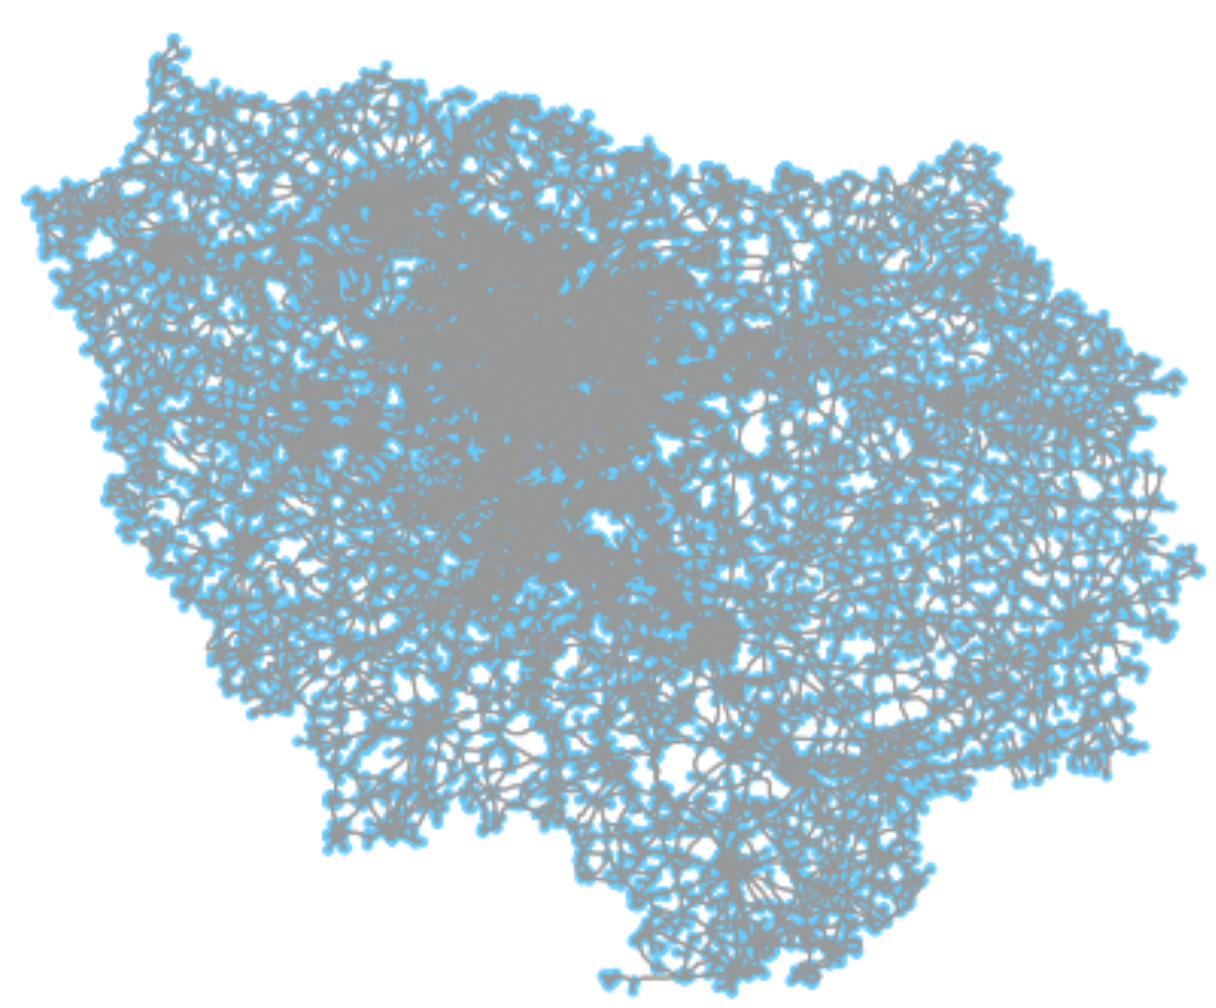

In [10]:
Image(filename = "graphe_idf.png", width=400)

##### <font style="color:#4D1AFB"> Conversion des données des entrepôts </font>

Le fichier csv contenant les emplacements des entrepôts est converti en une dataframe pandas **df_warehouses**

##### <font style="color:#4D1AFB"> Fonction générant des clients aléatoires </font>

La fonction **random_clients** ajoute à la suite d'une dataframe de points géographiques un certain nombre de points géographiques aléatoires.

La fonction prend en entrée :
- k : le nombre de clients qu'on veut générer aléatoirement
- df : une dataframe de points géographiques (par exemple le garage et les entrepôts)
Cette dataframe doit contenir des colonnes "y"(latitudes) et "x"(longitudes)   

La fonction retourne :
- df_complete : la dataframe complétée par les clients aléatoires 
- indices : un doublet de listes d'indices : (indices des entrepôts, indices des clients)

### Deuxième Partie: Construction d’un graphe modélisant le réseau

#### <font color = "blue"> Mise en forme du graphe: </font>

##### <font style="color:#4D1AFB"> Structure du graphe </font>
Le graphe visant à modéliser notre réseau de livraison est composé de trois générations:
+ La racine est le **garage**
+ Les enfants du garage sont les **entrepôts**
+ Les enfants d’un entrepôt sont les **clients** dont le colis est localisé dans cet entrepôt

Les arêtes sont:
+ **orientées** : du garage vers l'entrepot (on n'autorise pas à retourner au garage dans la journée) et de l'entrepot vers les clients (de meme, les camions passent une seule fois par l'entrepot par jour)
+ **non orientées**: entre les clients dont les colis se trouvent dans le meme entrepôt. En effet, c'est essentiellement le parcours entre un entrepôt et ses clients que l'on cherche à optimiser. Il faut donc que toutes les routes possibles soient admises, et donc que **chaque client soit relié aux autres**.

##### <font style="color:#4D1AFB"> La classe Node et ses filles </font>
Pour la réalisation du graphe, nous ne faisons pas appel à des classes ou méthodes de python particulières car nous construisons nous même une classe Node et une classe Graph. 

La classe **Node** est la brique élémentaire du graphe. Il s'agit d'une **classe générique** à partir de laquelle on construit les différents noeuds. Ainsi, plusieurs classes héritent de la classe Node et ce sont celles-ci que l’on utilise pour construire le graphe.

Un Node est caractérisé par: un identifiant unique (généré par la librairie uuid), des coordonnées géographiques (latitude et longitude) et des enfants (sous la forme d'une liste de Node). 

Les classes qui **héritent de Node** sont:
+ **Garage**: a une capacité maximale de camions (lourds et légers)
+ **Entrepot**: a une capacité maximale de camions et de stockage
+ **Colis**: n'a pas de coordonnées mais à la place une destination (les coordonnées du client correspondant), une taille et un entrepot d'origine
+ **Client**: si nécessaire, on peut ajouter la taille de son colis

<ins> NB:</ins> Dans notre implémentation, nous construisons toujours les clients à partir des colis (grace à la méthode make_graph), ce qui peut sembler redondant. Or, pour le moment, nous n'autorisons qu'un seul colis par client. De futurs développements amèneraient à considérer des clients commandant plusieurs colis d'où la nécessité de décorréler le colis de son client, et de créer des identifiants uniques pour chaque élément du graphe.

##### <font style="color:#4D1AFB"> La classe Vehicule</font>
La classe Vehicule est une classe générique pour représenter les différents véhicules et garder en mémoire leurs caractéristiques: capacité de stockage, pollution (bonus ou malus selon l'empreinte carbone du véhicule), distance maximale parcourue en un plein, possibilité de passer par une route étroite ou non, le temps de parcours du conducteur (la journée du travailleur est de 7h par exemple).

Notre algorithme utilise pour le moment des camions, représentés par la classe fille Camion. Par la suite, on pourra ajouter des véhicules plus légers ou des bicyclettes afin de réduire les émissions de CO2.


##### <font style="color:#4D1AFB"> La classe Graph</font>
La classe Graph permet de créer un graphe à 3 générations à partir des différents noeuds et selon les règles explicitées dans le premier paragraphe ci-dessus.
Un **Graph** prend en entrée:
+ un **Garage**
+ une **liste d'Entrepot**
+ une **liste de Colis**
+ un **Camion**

La méthode make_graph construit le graphe à partir des ces données.

La distance entre deux noeuds peut etre approximée en prenant la **distance euclidienne**. 
Mais, lorsqu'on veut optimiser un réseau de livraison, **il vaut mieux réfléchir en termes de distance effective parcourue le long des routes, ou en temps de trajet**. C'est ce que l'on utilisera par la suite, lorsqu'on construit le graphe à partir de données géographiques réelles.

Une **visualisation schématique** du graphe peut etre obtenue avec la méthode trace_graph (qui requiert l'installation de pygraphviz) . Voici, à titre illustratif, un exemple de graphe.

<u>NB:</u> Afin d'etre lisible, il vaut mieux ne pas avoir un très grand nombre de noeuds.

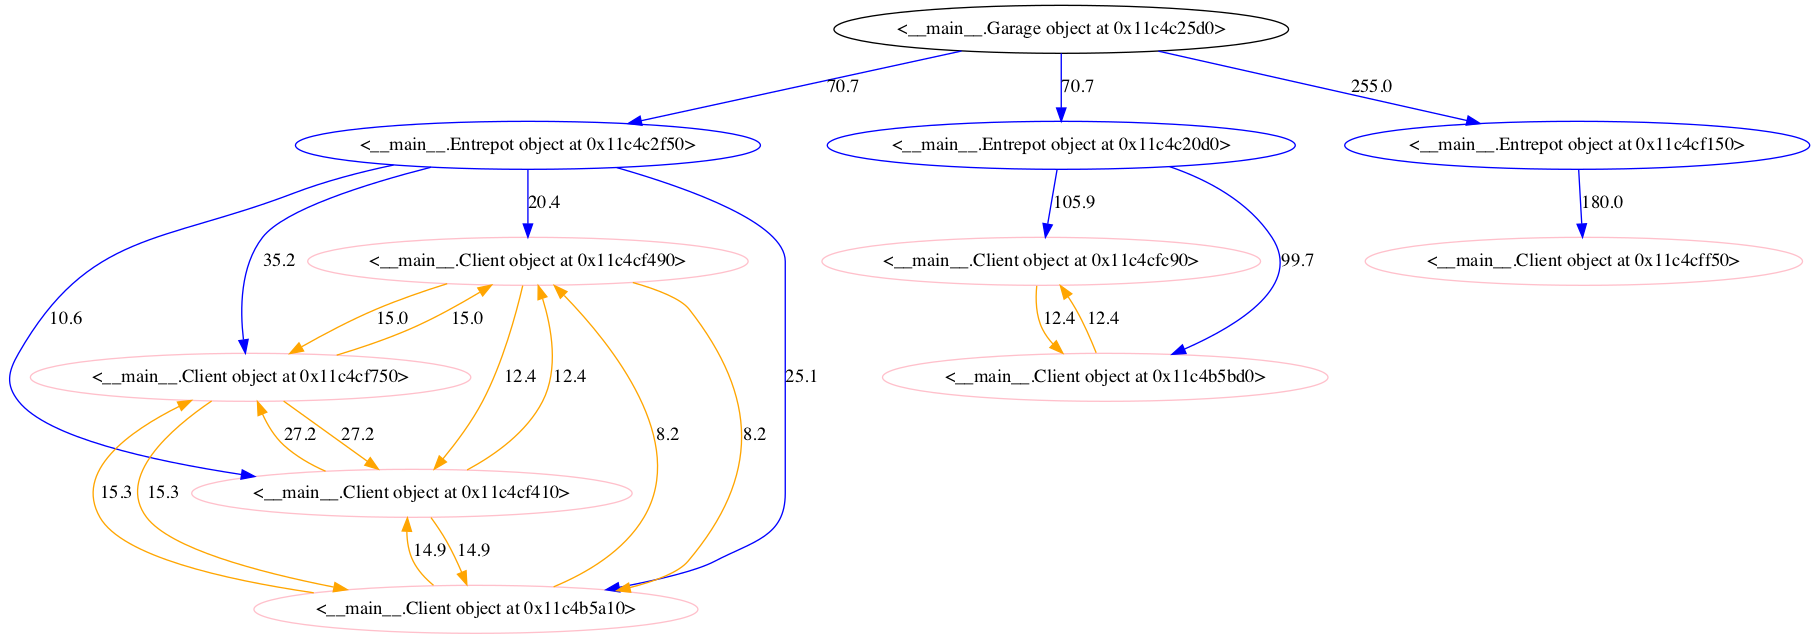

In [9]:
Image(filename = "graphe_exemple.png")

#### <font color = "blue"> A partir des données géographiques réelles </font>

#### <font style="color:#4D1AFB"> Acquisition des données </font>

La méthode random_clients du fichier warehouses_clients.py permet de générer un dataframe pandas contenant les entrepots (issus du fichier csv warehouses.csv) ainsi que k clients générés aléatoirement sur l'Ile-de-France. 
Les colonnes d'intéret du dataframe sont: latitude et longitude.

#### <font style="color:#4D1AFB"> Construction du graphe </font>
+ **Créer un Garage et un Camion**
+ Appeler la **méthode `make_graph_components`**: celle-ci construit, à partir du dataframe retourné par random_clients, une liste d'entrepots et une liste de colis (et donc de clients)
+ Appeler la **méthode `make_graph`** en passant en paramètre le garage, la liste d'entrepots, la liste de colis et le camion
+ Appeler la **méthode `make_dist_matrix(df)`** qui utilise la méthode `itineraries` qui génère la matrice des distances, ainsi que les coordonnées de chaque point et les itinéraires.

#### <font style="color:#4D1AFB"> Exportation des données du graphe sous la forme de fichiers csv </font>
La méthode `generate_csv` crée, **dans le dossier input_data, un fichier csv pour chaque entrepôt**.
Ce fichier contient les identifiants de chaque point, leurs coordonnées (entrepôt et les clients dont les colis se trouvent dans cet entrepot), la demande de l'entrepot ainsi que les distances entre chacun des points.

Cette méthode fait appel à la méthode `csv_entrepot` qui génère le fichier csv décrit ci-dessus pour un entrepôt en particulier. C'est dans cette méthode que l'on appelle la méthode `dist` qui calcule la distance entre deux noeuds.

La méthode `dist` prend en argument un Graph. Si la matrice des distances n'a pas été créée, la distance retournée est égale à la **distance euclidienne**. Sinon, la méthode utilise la **matrice des distances** créée à partir de la méthode itinerariese et passée en attribut du Graph. La **distance réelle** (en termes de temps de trajet ou de longueur du trajet) est alors renvoyée.

### Troisième Partie : Mise en place d'un algorithme d'optimisation génétique

On a choisi d'implémenter un algorithme génétique pour optimiser le réseau de livraison modélisé par le graphe créé en partie 2.

#### <font style="color:#4D1AFB"> Données nécessaires au bon fonctionnement de cet algorithme </font>
L'algorithme prend comme argument d'entrée les fichiers csv créés par la méthode __generate_csv__ de la classe Graphe, ainsi que la liste renvoyée par cette méthode, qui contient le nom des entrepots ainsi que leur nombre maximum de camions et le nombre de colis à livrer dans la journée. 

De plus, il faut avoir accès à l'attribut __garage.nb_camions__ de la classe Graphe pour avoir accès au nombre de camions disponibles en tout!

Nous fixons également un coût de livraison de 10min.
Les coûts temporels dont nous disposons étant en secondes, on va attribuer un coût par unité de temps égal à 1/3600, de façon à avoir un coût en heures.

#### <font style="color:#4D1AFB"> Implémentation de l'algorithme (fichier optim_gen.py) </font>
L'algorithme que nous avons choisi d'implémenter est un algorithme dit génétique, il repose sur les processus de sélection naturelle et d'évolution d'une population par mutations et crossovers, de génération en génération. Ainsi, il est nécessaire de bien définir notre individu pour l'adapter au problème que l'on considère, et il faut définir un nombre de générations ainsi qu'une taille de population.

Nous intégrons ensuite cet algorithme ainsi que d'autres fonctions auxiliaires dans une fonction qui génère des résultats sous forme de fichier csv dans le dossier __output_data__.

On va chercher à optimiser le trajet de livraison des camions. Notre algorithme s'exécute à partir des données issues d'un entrepot. Il faudra donc le réexécuter pour chaque entrepot dans notre fonction __results_vrptw__.

Pour expliquer le fonctionnement de la fonction __run_vrptw__ qui implémente l'algorithme génétique, nous nous plaçons alors dans un entrepot.


##### Création de l'individu
Les individus de notre population sont symbolisés par une liste ordonnée des clients à visiter, en concaténant les trajets de chaque camion partant de l'entrepot. Ainsi un individu [2,1,4,3] peut coder un trajet de la forme [[0,2,0],[0,1,4,0],[0,3,0]], (ici on considère donc 3 camions et 0 symbolise l'entrepot de référence). 

Cette identification n'est pas unique mais la fonction __ind2route__ du fichier __optim_gen.py__ fait en sorte de décoder l'individu en une journée de travail en maximisant les heures de travail d'un travailleur (sans dépasser 8 heures par jour) et les chargements des camions et donc en minimisant le nombre de camions utilisés.

Nous faisons ici au travers de cette fonction une première optimisation pour répondre aux besoin des réseaux de livraison en minimisant la pollution et le coût de salariés pour l'entrepot, en minimisant le nombre de camions utilisés.

##### Définition du coût engendré par chaque individu
Pour chaque individu de la population, on définit un coût correspondant au coût temporel total de l'individu, grâce aux données de coût issues de notre classe Graphe implémentée en deuxième partie. En sortie de notre fonction __evalVRPTW__, on conserve alors l'inverse de ce coût pour des raisons techniques, que l'on appelle __fitness__ et que l'on cherchera à maximiser dans notre algorithme génétique.

Ce coût temporel a été choisi de façon à répondre à un besoin d'efficacité pour l'entreprise qui gère cet entrepot et également un besoin de réduction de la pollution et du temps de travail des camionneurs.

##### Etapes de l'évolution
On définit ensuite les étapes de notre évolution : 

- les mutations : on considère uniquement des inversions de nucléotides et pas d'insertion ni de suppression d'un nucléotide. En effet, il faut livrer à tous les clients une unique fois dans la journée. Notre fonction __mut_inverse_indexes__ prend en argument un individu et inverse une séquence de la liste comprise *strictement* entre deux indices sélectionnés de manière aléatoire. A titre d'exemple, on peut exécuter le code ci-dessous, extrait du fichier __optim_gen__

In [50]:
import random
def mut_inverse_indexes(individual):
    '''
    Step of genetic algorithm : Mutation (only by inversion, to keep the unicity of each occurence) . No insertion or deletion allowed

    Input : individual (list)
    Output : mutated individual
    '''

    start, stop = sorted(random.sample(range(len(individual)), 2))
    print(f"indices d'inversion : {start, stop}")
    individual = individual[:start+1] + individual[stop:start:-1] + individual[stop+1:]
    return (individual, )
print(f"avant mutation :{[1,2,3,4,5,6,7,8,9]}")
print(f"après mutation : {mut_inverse_indexes([1,2,3,4,5,6,7,8,9])}")


avant mutation :[1, 2, 3, 4, 5, 6, 7, 8, 9]
indices d'inversion : (7, 8)
après mutation : ([1, 2, 3, 4, 5, 6, 7, 8, 9],)


- les crossover : la fonction  en entrée deux individus et on crée deux individus à partir de ceux-ci, en croisant une séquence de chaque liste, dont les indices de début et de fin sont choisis de manière aléatoire grâce à la fonction __random.sample__ . Ainsi, si nos individus valaient [1,4,3,6,5,2] et [4,3,5,2,1,6] et que l'on tire au hasard l'indice 2 et 4, on crée deux nouveaux individus valant: [3,6,5,4,2,1] et [3,5,2,1,4,6]

In [55]:
def cx_partialy_matched(ind1, ind2):
    '''
    Step of the genetic algorithm : crossover

    Input : two individuals (list)
    Output : two individuals that have been modified
    '''
    size = min(len(ind1), len(ind2))
    try:
        cxpoint1, cxpoint2 = sorted(random.sample(range(size), 2))
        print(f"les indices de début et de fin sont : {cxpoint1, cxpoint2}")
    except ValueError:
        print('Error : Only one package to deliver')
    temp1 = ind1[cxpoint1:cxpoint2+1] + ind2
    temp2 = ind2[cxpoint1:cxpoint2+1] + ind1
    ind1 = []
    for gene in temp1:
        if gene not in ind1:
            ind1.append(gene)
    ind2 = []
    for gene in temp2:
        if gene not in ind2:
            ind2.append(gene)
    return ind1, ind2

print(f"avant crossover :{[1,4,3,6,5,2], [4,3,5,2,6,1]}")
print(f"après mutation : {cx_partialy_matched([1,4,3,6,5,2], [4,3,5,2,6,1])}")


avant crossover :([1, 4, 3, 6, 5, 2], [4, 3, 5, 2, 6, 1])
les indices de début et de fin sont : (2, 5)
après mutation : ([3, 6, 5, 2, 4, 1], [5, 2, 6, 1, 4, 3])


##### Fonctionnement de l'algorithme

On utilise le module __deap__ et plus précisément ses attributs __create__, __base__ et __tools__.
A l'aide du module __create__, on impose à l'algorithme de chercher à maximiser le Fitness sur chaque génération, on crée égelament un individu affecté de son fitness.

On crée ensuite une instance de Toolbox grâce au module __base__, ainsi qu'un générateur qui nous sert à générer dans un ordre aléatoire les clients que nous devons livrer. 

Enfin, à l'aide de la méthode Toolbox.register de la classe base.Toolbox, on garde en mémoire notre individu, notre population, notre façon de sélectionner les individus pour la prochaine génération (à l'aide du module __tools__ et de sa fonction __selRoulette__, notre façon d'évaluer le coût (fonction __evalVRPTW__ que nous avons codé), ainsi que notre façon de muter un individu et de croiser deux individus.

Enfin on itère notre algorithme sur plusieurs générations, en évaluant le coût de chaque nouvel individu de la nouvelle population, et du meilleur individu de chaque génération. A la fin de l'évolution, on garde l'individu ayant le Fitness le plus élevé, soit le coût temporel le plus bas.

Pour qu'un tel algorithme fonctionne, il faut l'itérer sur un grand nombre de générations et sur une population de grande taille également, néanmoins pour des raisons de capacité de calcul, on se limite à une population de 50 individus et à une centaine de générations.
Les données d'entrée de notre algorithme sont issues de la classe Graphe implémentée, qui nous fournit la demande de chaque client ainsi que les coûts temporels de voyage entre chaque points du graphe (entrepot ou client).

#### <font style="color:#4D1AFB">Optimisation d'un réseau de livraison </font>

Après avoir créé notre algorithme génétique d'optimisation, il faut l'intégrer dans une fonction qui nous permet d'exporter des résultats utilisables sous forme d'un fichier csv, avec l'itinéraire de chaque camion sous forme de suite ordonnée de coordonnées GPS correspondant aux clients. En effet, jusqu'ici, on a travaillé uniquement avec des listes d'entiers correspondant à une attribution de numéro à chaque client, le nombre 0 étant affecté par défaut à l'entrepot, or dans la réalité, les données réellement exploitables sont des coordonnées GPS.

##### Décodage de nombres en coordonnées GPS

On a donc besoin dans un premier temps d'une fonction qui décode nos nombres en coordonnées GPS. On avait en fait utilisé l'index du dataframe d'entrée pour numéroter nos clients de manière unique pour la journée.
Cette fonction fait tourner notre algorithme sur chaque fichier csv correspondant à un entrepot et à l'aide des colonnes longitude et latitude du fichier d'entrée, génère les fichiers csv, dont les colonnes sont les différents camions et les lignes successives représentent l'itinéraire de chaque camion (chaque point de la ligne i correspond à un tuple contenant les coordonnées GPS du client ou de l'entrepot visité en ième place.

Ainsi, pour un graphe donné, il faut exécuter cette fonction pour obtenir les résultats demandés.

####  <font style="color:#4D1AFB"> Simulation et optimisation du réseau de livraison en région parisienne </font>

Après avoir réussi à optimiser un réseau de livraison fixé, on crée une fonction __simulation_vrptw__ qui regroupe toutes nos fonctions précédentes pour simuler un réseau de livraison optimisé à partir d'une liste de clients placés aléatoirement sur la carte de l'Ile de France. A partir de cela, on reprend la classe __Graph__ et son attribut __create_graph_components__ pour créer notre réseau, que l'on exporte ensuite sous forme de fichier csv dans le dossier __input_data__.

Ensuite, on filtre les entrepots pour lesquels il n'y a pas de colis à livrer avec la fonction __no_client_to_deliver__, puis on traite séparément le cas où il n'y a qu'un seul client à livrer avec __one_client_to_deliver__ pour ne pas lever d'exception dans notre algorithme VRPTW qui renvoie une __Value Error__ si la dataframe d'entrée ne comprend qu'un seul client à livrer...

Enfin, on applique notre algorithme VRPTW et enfin, on utilise la fonction __decode_to_GPS__ pour exporter nos résulats dans le dossier __output_data__.